In [1]:
import pandas as pd
import numpy as np
import h5py
import torch
import torch.nn as nn
import random
import sys
import os

#trying to ensure reproducibility
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [2]:
# Setting path to load util functions
from pathlib import Path
parent_dir = Path.cwd().parents[1]
sys.path.append(os.path.abspath(parent_dir))

In [3]:
experiment_num = 25

In [4]:
#Loading data
with h5py.File('../../data/3d_array/mod_train_data_3d_h5.h5', 'r') as f:
    train_X = f['train_data_3d'][:]
with h5py.File('../../data/3d_array/mod_val_data_3d_h5.h5', 'r') as f:
    val_X = f['val_data_3d'][:]
with h5py.File('../../data/3d_array/mod_test_data_3d_h5.h5', 'r') as f:
    test_X = f['test_data_3d'][:]

train_y = pd.read_parquet('../../data/3d_array/train_targets.parquet')
val_y = pd.read_parquet('../../data/3d_array/val_targets.parquet')
test_y = pd.read_parquet('../../data/3d_array/test_targets.parquet')

In [5]:
train_X = np.nan_to_num(train_X, nan=0.0)
val_X = np.nan_to_num(val_X, nan=0.0)
test_X = np.nan_to_num(test_X, nan=0.0)

In [6]:
train_y['end_of_month'].value_counts()

end_of_month
2018-03-31    289115
Name: count, dtype: int64

In [7]:
train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]
test_y = test_y[test_y['end_of_month'].isin(['2018-03-31'])]

C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_19828\847019464.py:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  train_y = train_y[train_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_19828\847019464.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  val_y = val_y[val_y['end_of_month'].isin(['2018-03-31'])]
C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_19828\847019464.py:3: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be c

In [8]:
train_y.sort_values(by=['customer_ID'])

,customer_ID,end_of_month,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2018-03-31,0
1,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,2018-03-31,0
2,000084e5023181993c2e1b665ac88dbb1ce9ef621ec537...,2018-03-31,0
3,000098081fde4fd64bc4d503a5d6f86a0aedc425c96f52...,2018-03-31,0
4,0000f99513770170a1aba690daeeb8a96da4a39f11fc27...,2018-03-31,1
...,...,...,...
289110,fffe3ec7cdbc1caac845c884b389ed347bfc1da9d09731...,2018-03-31,1
289111,fffef3305f19a11fb6c15f4ebe9be1bd664540e57c0a6a...,2018-03-31,0
289112,ffff39cc22a375d07369980d02d617883dd28ad81a6aa3...,2018-03-31,0
289113,ffff518bb2075e4816ee3fe9f3b152c57fc0e6f01bf7fd...,2018-03-31,0


In [9]:
train_X.shape, train_y.shape

((289115, 13, 86), (289115, 3))

In [10]:
val_X.shape, val_y.shape

((32124, 13, 86), (32124, 3))

In [11]:
class ParallelConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_sizes=[3, 5, 7], dropout_rate=0.2):
        """
        Parallel Convolutional Block that processes input through multiple convolutional paths
        with different kernel sizes and concatenates the results.
        
        Args:
            in_channels: Number of input channels
            out_channels: Number of output channels
            kernel_sizes: List of kernel sizes for parallel convolutions
            dropout_rate: Dropout probability
        """
        super(ParallelConvBlock, self).__init__()
        
        self.n_paths = len(kernel_sizes)
        # Calculate channels per path
        path_channels = out_channels // self.n_paths
        
        # Create parallel convolutional paths
        self.paths = nn.ModuleList()
        for k_size in kernel_sizes:
            padding = k_size // 2  # Same padding to maintain sequence length
            path = nn.Sequential(
                nn.Conv1d(in_channels, path_channels, kernel_size=k_size, padding=padding),
                nn.BatchNorm1d(path_channels),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            )
            self.paths.append(path)
            
        # Projection layer to ensure output has exactly out_channels
        self.projection = nn.Sequential(
            nn.Conv1d(path_channels * self.n_paths, out_channels, kernel_size=1),
            nn.BatchNorm1d(out_channels),
            nn.ReLU()
        )
    
    def forward(self, x):
        # Process input through parallel paths
        outputs = [path(x) for path in self.paths]
        
        # Concatenate along channel dimension
        # print(f"Outputs shape before concatenation: {[out.shape for out in outputs]}")
        x = torch.cat(outputs, dim=1)
        
        # Apply projection to get final output
        x = self.projection(x)
        
        return x

In [12]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1, pool=True, dropout=0.3):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=padding)
        self.bn = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(kernel_size=2) if pool else None
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        if self.pool:
            x = self.pool(x)
        x = self.dropout(x)
        return x

In [13]:
class ConvLSTMModel(nn.Module):
    def __init__(self, input_size, lstm_hidden_size=64, num_lstm_layers=1, output_size=1):
        """
        Args:
            input_size (int): Number of features in the input sequence (feature dimension).
            lstm_hidden_size (int): Hidden size for the LSTM layer.
            num_lstm_layers (int): Number of layers for the LSTM.
            output_size (int): Size of the final output (e.g., 1 for binary classification).
        """
        super(ConvLSTMModel, self).__init__()

        self.input_size = input_size
        self.lstm_hidden_size = lstm_hidden_size

        # --- CNN Path ---
        # First convolutional block (Parallel)
        # Input channels = input_size (features)
        cnn_out_channels_1 = 100
        self.parallel_conv = ParallelConvBlock(input_size, cnn_out_channels_1, kernel_sizes=[3, 5, 7, 9], dropout_rate=0.2)

        # Second convolutional block
        cnn_out_channels_2 = 64
        self.block2 = ConvBlock(cnn_out_channels_1, cnn_out_channels_2, dropout=0.2)

        # Third convolutional block
        self.cnn_final_channels = 32
        self.block3 = ConvBlock(cnn_out_channels_2, self.cnn_final_channels, pool=False, dropout=0.2) # No pooling in the last block

        # Global pooling for CNN path
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)

        # --- LSTM Path ---
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=lstm_hidden_size,
                            num_layers=num_lstm_layers,
                            batch_first=True, # Crucial: input shape (batch, seq_len, features)
                            bidirectional=False) # Set to True if needed, adjust feature concatenation below

        # --- Combined Path ---
        # Calculate the combined feature size after CNN pooling and LSTM
        combined_features = self.cnn_final_channels + lstm_hidden_size # Add *2 if bidirectional LSTM

        # Fully connected layers
        self.fc1 = nn.Linear(combined_features, 16) # Input size adjusted
        self.relu_fc1 = nn.ReLU()
        self.dropout_fc1 = nn.Dropout(0.3) # Added dropout for FC layer
        self.fc2 = nn.Linear(16, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Input shape: batch_size x time_steps x features

        # --- CNN Path ---
        # For Conv1D: convert to batch_size x features(channels) x time_steps
        x_cnn = x.permute(0, 2, 1)
        # Pass through convolutional blocks
        cnn_out = self.parallel_conv(x_cnn)
        cnn_out = self.block2(cnn_out)
        cnn_out = self.block3(cnn_out)
        # Global pooling to get fixed-size representation for CNN path
        cnn_pooled = self.global_avg_pool(cnn_out)
        cnn_features = cnn_pooled.view(cnn_pooled.size(0), -1) # Flatten: batch_size x cnn_final_channels

        # --- LSTM Path ---
        # Input shape expected by LSTM (batch_first=True): batch_size x time_steps x features
        # No permutation needed for LSTM path if input is already in this format
        lstm_out, (h_n, c_n) = self.lstm(x)
        # We typically use the last hidden state
        # h_n shape: (num_layers * num_directions, batch_size, lstm_hidden_size)
        # Get the hidden state of the last layer
        lstm_features = h_n[-1] # Shape: batch_size x lstm_hidden_size (if not bidirectional)
        # If bidirectional: h_n shape is (num_layers*2, batch, hidden_size)
        # You might want to concatenate the last forward and backward hidden states:
        # lstm_features = torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1) # If bidirectional

        # --- Concatenate Features ---
        combined_features = torch.cat((cnn_features, lstm_features), dim=1)

        # --- Fully Connected Layers ---
        x = self.fc1(combined_features)
        x = self.relu_fc1(x)
        x = self.dropout_fc1(x)
        x = self.fc2(x)

        # Output probability
        return self.sigmoid(x)

In [14]:
# Initialize the ConvModel
input_size = train_X.shape[2]  # Number of features
output_size = 1  # Binary classification
lstm_hidden_size = 128
num_lstm_layers = 1

# Create model instance
model = ConvLSTMModel(input_size=input_size, output_size=output_size, lstm_hidden_size=lstm_hidden_size, num_lstm_layers=num_lstm_layers)
print(f"Model initialized with input_size={input_size}, output_size={output_size}")

Model initialized with input_size=86, output_size=1


In [16]:
# Define the model path
model_path = f'../../models/deep_learning/experiment_{experiment_num}.pth'

# Load the model parameters
try:
    # Load the saved dictionary
    checkpoint = torch.load(model_path)
    
    # Extract model parameters from the 'model_state_dict' key
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model parameters loaded successfully from {model_path}")
except FileNotFoundError:
    print(f"Model file not found at {model_path}")
    print("Please specify the correct path to the model parameters")
except KeyError:
    print(f"'model_state_dict' key not found in the checkpoint file")
    print("The file may have been saved with a different structure")
except Exception as e:
    print(f"Error loading model parameters: {str(e)}")

Model parameters loaded successfully from ../../models/deep_learning/experiment_25.pth


C:\Users\vaseekaranv\AppData\Local\Temp\ipykernel_19828\4247502569.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


In [17]:
batch_size = 2048
from torchinfo import summary
summary(model, input_size=(batch_size, train_X.shape[1], train_X.shape[2]), device='cpu',
        col_names=["input_size", "kernel_size","output_size", "num_params"], depth = 1)

Layer (type:depth-idx)                   Input Shape               Kernel Shape              Output Shape              Param #
ConvLSTMModel                            [2048, 13, 86]            --                        [2048, 1]                 --
├─ParallelConvBlock: 1-1                 [2048, 86, 13]            --                        [2048, 100, 13]           62,200
├─ConvBlock: 1-2                         [2048, 100, 13]           --                        [2048, 64, 6]             19,392
├─ConvBlock: 1-3                         [2048, 64, 6]             --                        [2048, 32, 6]             6,240
├─AdaptiveAvgPool1d: 1-4                 [2048, 32, 6]             --                        [2048, 32, 1]             --
├─LSTM: 1-5                              [2048, 13, 86]            --                        [2048, 13, 128]           110,592
├─Linear: 1-6                            [2048, 160]               --                        [2048, 16]                2,576


In [18]:
from torch.utils.data import Dataset, DataLoader
class TimeSeriesDataset(Dataset):
    def __init__(self, data, targets):
        """
        Args:
            data: numpy array of shape (num_ids, time_steps, features)
            targets: numpy array of shape (num_ids,)
        """
        self.data = torch.FloatTensor(data)
        self.targets = torch.FloatTensor(targets).unsqueeze(1)  # Add dimension for output
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.targets[idx]

In [19]:
train_dataset = TimeSeriesDataset(train_X, train_y['target'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [20]:
val_dataset = TimeSeriesDataset(val_X, val_y['target'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [21]:
test_dataset = TimeSeriesDataset(test_X, test_y['target'].values)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [22]:
train_dataset.__getitem__(0)[0].shape, train_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([0.]))

In [23]:
val_dataset.__getitem__(0)[0].shape, val_dataset.__getitem__(0)[1]

(torch.Size([13, 86]), tensor([1.]))

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [25]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, confusion_matrix

# Set model to evaluation mode
model.eval()

# Check if CUDA is available and move model to the appropriate device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Lists to store predictions and true values
all_preds = []
all_labels = []

# Perform inference without gradient calculation
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move inputs and labels to the appropriate device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(inputs)
        
        # Store predictions and labels
        all_preds.append(outputs.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Concatenate all batches
all_preds = np.concatenate(all_preds)
all_labels = np.concatenate(all_labels)

# Convert predictions to binary (0 or 1) using threshold of 0.5
pred_classes = (all_preds > 0.5).astype(int)
true_classes = all_labels.astype(int)

# Generate classification report

# Print classification report
print("Classification Report:")
print(classification_report(true_classes, pred_classes, digits = 4))

# Calculate and print accuracy
accuracy = accuracy_score(true_classes, pred_classes)
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print ROC-AUC score
auc = roc_auc_score(true_classes, all_preds)
print(f"ROC-AUC Score: {auc:.4f}")

# Print confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(true_classes, pred_classes))

Classification Report:
              precision    recall  f1-score   support

           0     0.9202    0.9353    0.9276    102026
           1     0.8056    0.7678    0.7862     35648

    accuracy                         0.8919    137674
   macro avg     0.8629    0.8515    0.8569    137674
weighted avg     0.8905    0.8919    0.8910    137674

Accuracy: 0.8919
ROC-AUC Score: 0.9530

Confusion Matrix:
[[95420  6606]
 [ 8279 27369]]


Target Recall: >= 0.9800 for Class 0
Threshold found by Binary Search: 0.7502944
Achieved Recall at Threshold: 0.9800
Classification Report:
              precision    recall  f1-score   support

     Class 0     0.8597    0.9800    0.9159    102026
     Class 1     0.9046    0.5424    0.6782     35648

    accuracy                         0.8667    137674
   macro avg     0.8822    0.7612    0.7971    137674
weighted avg     0.8713    0.8667    0.8544    137674



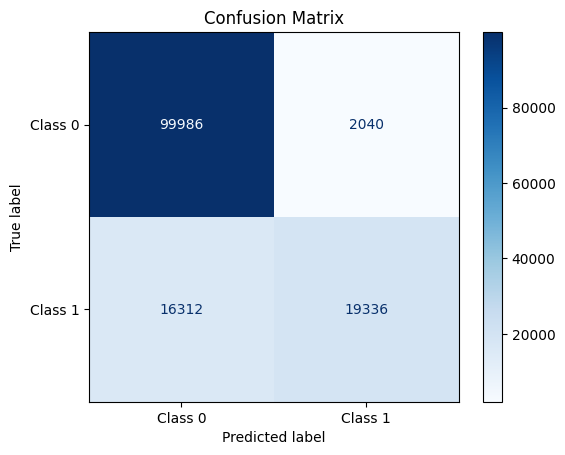

0.7502944469451904

In [26]:
from utils.eval_helpers import evaluate_model_for_recall
evaluate_model_for_recall(target_class=0, desired_recall=0.98, y_true=true_classes, y_pred_proba=all_preds)

In [27]:
for name, module in model.named_modules():
    # 'name' is the hierarchical string name
    # 'module' is the actual layer/module object
    print(f"Name: '{name}' \t Module Type: {module.__class__.__name__}")

Name: '' 	 Module Type: ConvLSTMModel
Name: 'parallel_conv' 	 Module Type: ParallelConvBlock
Name: 'parallel_conv.paths' 	 Module Type: ModuleList
Name: 'parallel_conv.paths.0' 	 Module Type: Sequential
Name: 'parallel_conv.paths.0.0' 	 Module Type: Conv1d
Name: 'parallel_conv.paths.0.1' 	 Module Type: BatchNorm1d
Name: 'parallel_conv.paths.0.2' 	 Module Type: ReLU
Name: 'parallel_conv.paths.0.3' 	 Module Type: Dropout
Name: 'parallel_conv.paths.1' 	 Module Type: Sequential
Name: 'parallel_conv.paths.1.0' 	 Module Type: Conv1d
Name: 'parallel_conv.paths.1.1' 	 Module Type: BatchNorm1d
Name: 'parallel_conv.paths.1.2' 	 Module Type: ReLU
Name: 'parallel_conv.paths.1.3' 	 Module Type: Dropout
Name: 'parallel_conv.paths.2' 	 Module Type: Sequential
Name: 'parallel_conv.paths.2.0' 	 Module Type: Conv1d
Name: 'parallel_conv.paths.2.1' 	 Module Type: BatchNorm1d
Name: 'parallel_conv.paths.2.2' 	 Module Type: ReLU
Name: 'parallel_conv.paths.2.3' 	 Module Type: Dropout
Name: 'parallel_conv.path

In [29]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import torch # Make sure torch is imported

def extract_features_with_hook(model: nn.Module, target_layer_name: str, data_loader: torch.utils.data.DataLoader, device: torch.device) -> pd.DataFrame:
    """
    Runs inference using the model and extracts features from a specific layer
    using forward hooks, without modifying the model's forward method.

    Args:
        model: The trained PyTorch model (original version).
        target_layer_name: The string name of the layer to extract features from
                           (e.g., 'dropout_fc1'). Must be an attribute of the model.
        data_loader: DataLoader for the dataset (e.g., validation or test).
        device: The device to run inference on ('cuda' or 'cpu').

    Returns:
        A pandas DataFrame containing the extracted features and corresponding labels.
    """
    model.eval()  # Set the model to evaluation mode
    captured_features = []
    all_labels = []

    # --- Hook Function ---
    # This function will run every time the target layer computes its output
    def hook_fn(module, input, output):
        # The hook captures the output tensor of the layer
        # Detach from graph, move to CPU, convert to numpy, and append
        captured_features.append(output.detach().cpu().numpy())
    # --------------------

    # --- Find and Register Hook ---
    hook_handle = None
    target_layer = None
    try:
        # Access the target layer using its attribute name
        target_layer = dict(model.named_modules())[target_layer_name]
        # Register the forward hook
        hook_handle = target_layer.register_forward_hook(hook_fn)
        print(f"Registered forward hook on layer: {target_layer_name}")
    except KeyError:
        print(f"Error: Layer '{target_layer_name}' not found in the model.")
        # Print available layer names for debugging
        print("Available named modules:")
        for name, _ in model.named_modules():
             print(f"- {name}")
        return pd.DataFrame() # Return empty DataFrame
    except Exception as e:
        print(f"An error occurred during hook registration: {e}")
        return pd.DataFrame()
    # ---------------------------

    print(f"Extracting features using device: {device}")
    with torch.no_grad(): # Disable gradient calculations
        pbar = tqdm(data_loader, desc="Extracting Features")
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            original_labels = labels.numpy() # Keep labels on CPU

            # Run the forward pass. We don't need the model's return value,
            # but running it triggers the forward hook on the target layer.
            _ = model(inputs)

            all_labels.append(original_labels)

    # --- Remove the Hook ---
    # IMPORTANT: Always remove hooks when done to avoid memory leaks
    if hook_handle:
        hook_handle.remove()
        print(f"Removed forward hook from layer: {target_layer_name}")
    # -----------------------

    # --- Process Captured Features ---
    if not captured_features:
        print("Warning: No features were captured. Check data_loader and model.")
        return pd.DataFrame()

    all_features_np = np.concatenate(captured_features, axis=0)
    all_labels_np = np.concatenate(all_labels, axis=0)

    # Ensure labels are flattened
    if all_labels_np.ndim > 1 and all_labels_np.shape[1] == 1:
        all_labels_np = all_labels_np.flatten()

    # Create pandas DataFrame
    num_features = all_features_np.shape[1]
    feature_columns = [f'DL_{i}' for i in range(num_features)]
    features_df = pd.DataFrame(all_features_np, columns=feature_columns)
    features_df['label'] = all_labels_np

    print(f"Feature extraction complete. DataFrame shape: {features_df.shape}")
    return features_df

In [32]:
target_layer_name = 'dropout_fc1' # Make sure this matches!

extracted_df = extract_features_with_hook(
    model,
    target_layer_name,
    test_loader,
    device
)

Registered forward hook on layer: dropout_fc1
Extracting features using device: cuda:0


Extracting Features:   0%|          | 0/68 [00:00<?, ?it/s]

Removed forward hook from layer: dropout_fc1
Feature extraction complete. DataFrame shape: (137674, 17)


In [33]:
extracted_df.head()

,DL_0,DL_1,DL_2,DL_3,DL_4,DL_5,DL_6,DL_7,DL_8,DL_9,DL_10,DL_11,DL_12,DL_13,DL_14,DL_15,label
0,6.035169,5.707216,0.000000,5.636570,0.000000,6.809452,5.764231,6.173485,0.000000,0.00000,0.000000,0.000000,6.153308,4.215621,6.063298,0.000000,0.0
1,4.716325,4.411739,0.000000,4.441925,0.000000,5.319164,4.509210,4.714250,0.000000,0.00000,0.000000,0.000000,4.894351,3.420918,4.600852,0.000000,0.0
2,3.970655,3.554694,0.000000,3.736287,0.000000,4.512755,3.706461,3.885978,0.000000,0.00000,0.000000,0.000000,4.245215,2.843341,3.793341,0.000000,0.0
3,5.287063,4.879447,0.000000,5.274143,0.000000,6.075306,5.021643,5.275514,0.000000,0.00000,0.000000,0.000000,5.387375,3.880430,5.249128,0.000000,0.0
4,0.000000,0.000000,3.338976,0.000000,1.966514,0.000000,0.000000,0.000000,2.390673,1.96816,2.084374,1.777916,0.000000,0.000000,0.000000,1.780722,1.0
